In [103]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical, load_img, img_to_array
from sklearn.metrics import confusion_matrix
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
os.listdir("dataset1/")

['readme.txt', 'known_images', 'unknown_images']

Load all the images

In [105]:
def load_images():
    images_dir = Path('dataset1/known_images/')
    normal_images = images_dir.glob('normal*.png')
    sick_images = images_dir.glob('sick*.png')
    img_data = []
    label_data = []
    for img in normal_images:
        img_data.append(img)
        label_data.append('normal')
    for img in sick_images:
        img_data.append(img)
        label_data.append('sick')
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df['labels'] = label_data
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [106]:
df_known_images = load_images()

df_known_images

,images,labels
0,dataset1\known_images\normal_261.png,normal
1,dataset1\known_images\normal_673.png,normal
2,dataset1\known_images\normal_334.png,normal
3,dataset1\known_images\sick_186.png,sick
4,dataset1\known_images\sick_0.png,sick
...,...,...
710,dataset1\known_images\normal_98.png,normal
711,dataset1\known_images\sick_187.png,sick
712,dataset1\known_images\normal_62.png,normal
713,dataset1\known_images\normal_89.png,normal


In [107]:
df_known_images.shape

(715, 2)

We now check if the data is balanced

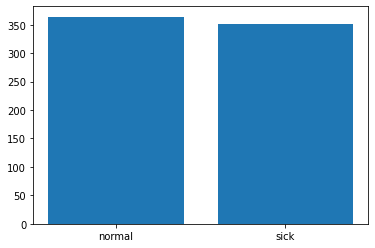

In [108]:
plt.bar(df_known_images['labels'].value_counts().index, df_known_images['labels'].value_counts().values)
plt.show()

Visualise some of the images

In [109]:
def visualise_images(images, labels):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(images[i]))
        img = cv2.resize(img, (224, 224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')

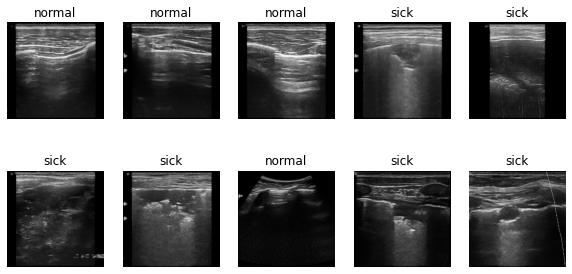

In [110]:
visualise_images(df_known_images['images'], df_known_images['labels'])

Split the data into Test and Training

In [111]:
def get_dataset_partitions_pd(df, train_split=0.8):
    train=df.sample(frac=train_split,random_state=200) #random state is a seed value

    test_validation=df.drop(train.index)

    test=test_validation.sample(frac=0.5,random_state=200) 

    validation = test_validation.drop(test.index)

    assert len(df) == len(train) + len(test) + len(validation) 

    return train, validation, test


In [112]:
train_ds, val_ds, test_ds = get_dataset_partitions_pd(df_known_images)


In [113]:
test_ds

,images,labels
87,dataset1\known_images\sick_168.png,sick
188,dataset1\known_images\sick_154.png,sick
462,dataset1\known_images\normal_276.png,normal
567,dataset1\known_images\normal_29.png,normal
90,dataset1\known_images\sick_141.png,sick
...,...,...
284,dataset1\known_images\sick_184.png,sick
714,dataset1\known_images\normal_94.png,normal
187,dataset1\known_images\normal_13.png,normal
29,dataset1\known_images\sick_129.png,sick


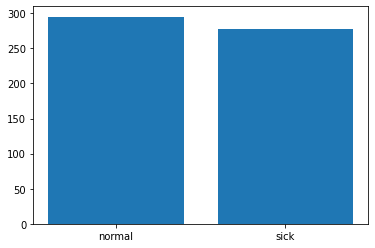

In [114]:
plt.bar(train_ds['labels'].value_counts().index, train_ds['labels'].value_counts().values)
plt.show()

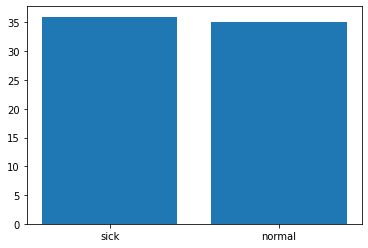

In [115]:
plt.bar(val_ds['labels'].value_counts().index, val_ds['labels'].value_counts().values)
plt.show()

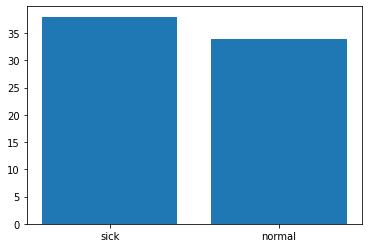

In [116]:
plt.bar(test_ds['labels'].value_counts().index, test_ds['labels'].value_counts().values)
plt.show()

Prepare the Validation Dataset

In [117]:
def prepare_dataset(images):

    normal_cases = images.loc[images['labels'] == 'normal']
    sick_cases = images.loc[images['labels'] == 'sick']
    data, labels = ([] for x in range(2))
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(224,224))
            #img = cv2.resize(img,(800,800))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if 'normal' in case['labels'].values:
                #print(case['labels'])
                label = to_categorical(0 , num_classes=2)
            else:
                #print(case['labels'])
                label = to_categorical(1 , num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(normal_cases)
    d,l = prepare(sick_cases)
    #print(l)
    d = np.array(d)
    l = np.array(l)
    return d,l

In [118]:
val_data, val_labels = prepare_dataset(val_ds)
#print(val_data)

We’ll now write a function to generate images in batches from the train set.

In [119]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32) 
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)

    # get a numpy array of all the indices of the input data
    indices = np.arange(n) 

    # initialize a counter
    i = 0
    while True:
        np.random.shuffle(indices)
        # Get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label=='normal':
                label=0
            else:
                label=1
            #one hot encoding
            encoded_label = to_categorical(label, num_classes=2)

            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224, 224))

            # check if it's grayscale
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default

            #orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            count+=1

            if count==batch_size-1:
                break
        
        i+=1
        yield batch_data, batch_labels

        if i>=steps:
            i=0



In [120]:
# Testing the data generation function
data_gen(train_ds, 160)

<generator object data_gen at 0x0000020396B743C0>

We now build the Deep Learning CNN Model for prediction

In [121]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))



A ReLu activation is applied after every convolution to transform the output values between the range 0 to 1. Max pooling is used to downsample the input representation. It helps the model to deal with overfitting by providing an abstract representation and also reduces the computational cost. 

In [122]:
batch_size = 16
nb_epochs = 3

# Fetch the training data from the generator
train_data_gen = data_gen(data=train_ds, batch_size=batch_size)

# define number of training steps
nb_train_steps =  train_ds.shape[0]//batch_size

print(train_ds.shape)

print(train_data_gen)

print("Number of training and validation steps: {} and {} ".format(nb_train_steps, len(val_ds)))

(572, 2)
<generator object data_gen at 0x00000203ADF737D0>
Number of training and validation steps: 35 and 71 


Batch size refers to the number of images fed to the network in a single forward pass. On the other hand, the number of epochs determines the number of times our network would process the whole training data. The number of training steps is the number of steps in one epoch and is calculated by dividing the size of our training data by the batch size. 

We’ll use binary cross-entropy as our loss function because we have only 2 classes. Rmsprop will be our optimizer function. Let’s start training.

In [123]:
model.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

# Fit the model
history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data,val_labels))

Epoch 1/3
35/35 [==============================] - 19s 531ms/step - loss: 0.5638 - accuracy: 0.6857 - val_loss: 0.5904 - val_accuracy: 0.6620
Epoch 2/3
35/35 [==============================] - 21s 614ms/step - loss: 0.2824 - accuracy: 0.8357 - val_loss: 0.2895 - val_accuracy: 0.9014
Epoch 3/3
35/35 [==============================] - 21s 605ms/step - loss: 0.1379 - accuracy: 0.8839 - val_loss: 0.2282 - val_accuracy: 0.9155


In [124]:
test_data, test_labels = prepare_dataset(test_ds)
print(test_data.shape)

(72, 224, 224, 3)


In [125]:
loss, acc = model.evaluate(test_data, test_labels,batch_size=16)
print('Loss and accuracy',loss,'&',acc)

5/5 [==============================] - 0s 83ms/step - loss: 0.1328 - accuracy: 0.9861
Loss and accuracy 0.13282592594623566 & 0.9861111044883728


In [126]:
# Get predictions
pred = model.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

# original labels
labels = np.argmax(test_labels, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

5/5 [==============================] - 0s 81ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      0.97      0.99        38

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



<AxesSubplot:>

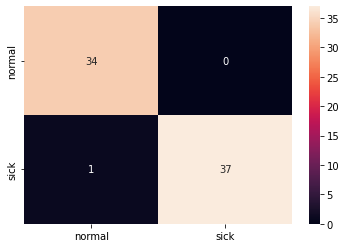

In [127]:
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['normal', 'sick'],yticklabels=['normal', 'sick'] )

It is quite evident that our validation accuracy is not that good. <br>There are a number of tricks that you can use to get good performance.
<ul>
<li>Change the batch size.</li>
<li>Train for more epochs.</li>
<li>Use a different optimizer.</li> 
<li>Tweak the neural network by adding/ removing layers.</li>
</ul>
<br>
The list can really go on. The important thing to note here is that trying out all these things is time-consuming and it may or may not work.

So, what’s the alternative?

**Transfer Learning** <br>
Training a neural network from scratch can require a lot of data, processing power, and time which can be unavailable or impractical most times. Transfer learning is a technique of using pre-trained neural networks that are trained on billions of images( like Alexnet, Inception net, VGG16)  on a different task by changing the last classification layer. Now, you might be thinking what’s the benefit and how this works? Like I have mentioned above, the initial layers learn very general features and as we go higher up in the network, the layers tend to learn patterns more specific to the task it is being trained on. Since the pre-trained models are trained on a huge number of images they can do a better job at learning these abstract features than the neural network written from scratch.

We will use pre-trained VGG16 

In [128]:
def vgg16_model(num_of_classes = None):
    model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

    x=Dense(1024, activation='relu')(model.layers[-4].output)
    x=Dropout(0.7)(x)
    x=Dense(512, activation='relu')(x)
    x=Dropout(0.5)(x)
    x=Dense(2, activation='softmax')(x)
    model=Model(model.input, x)

    return model

In [129]:
vgg_conv = vgg16_model(2)
for layer in vgg_conv.layers[:-10]:
    layer.trainable = False

In [130]:
opt =  Adam(learning_rate=0.0001, decay=1e-5)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

In [131]:
# Fit the model
history = vgg_conv.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data,val_labels),
                        class_weight={0:1.0, 1:0.4})

Epoch 1/3
35/35 [==============================] - 102s 3s/step - loss: 0.3548 - accuracy: 0.6750 - val_loss: 0.3992 - val_accuracy: 0.8732
Epoch 2/3
35/35 [==============================] - 102s 3s/step - loss: 0.0964 - accuracy: 0.9107 - val_loss: 0.3634 - val_accuracy: 0.9155
Epoch 3/3
35/35 [==============================] - 99s 3s/step - loss: 0.0601 - accuracy: 0.9464 - val_loss: 0.1917 - val_accuracy: 0.9437


In [132]:
test_data, test_labels = prepare_dataset(test_ds)

Now let's test performance of the model against the test dataset

In [133]:
loss, acc = vgg_conv.evaluate(test_data, test_labels,batch_size=16)
print('Loss and accuracy',loss,'&',acc)

5/5 [==============================] - 9s 2s/step - loss: 0.1217 - accuracy: 0.9861
Loss and accuracy 0.12171958386898041 & 0.9861111044883728


In [134]:
# Get predictions
pred = vgg_conv.predict(test_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

# original labels
labels = np.argmax(test_labels, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

5/5 [==============================] - 9s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        34
           1       0.97      1.00      0.99        38

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



<AxesSubplot:>

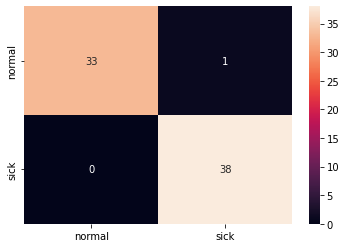

In [135]:
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['normal', 'sick'],yticklabels=['normal', 'sick'] )

We now label the unknown images.<br>
Let us first load them

In [136]:
def load_unknown_images():
    images_dir = Path('dataset1/unknown_images/')
    images = images_dir.glob('*.png')
    img_data = []
    for img in images:
        img_data.append(img)
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [137]:
df_unknown_images = load_unknown_images()

df_unknown_images.shape

(50, 1)

In [138]:
def prepare_dataset_unknown(images):
  
    data = []
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(224,224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            data.append(img)
        return data
    
    d = prepare(images)
    #print(l)
    d = np.array(d)
    return d

In [139]:
unknown_data = prepare_dataset_unknown(df_unknown_images)

In [140]:
unknown_data.shape

(50, 224, 224, 3)

In [141]:
# Get predictions
pred = vgg_conv.predict(unknown_data, batch_size=16)
#print(pred)
pred = np.argmax(pred, axis=-1)
print(pred)

4/4 [==============================] - 6s 1s/step
[0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1
 1 1 0 1 1 1 1 0 0 1 1 1 0]


In [142]:
df_unknown_images["predictions (0-Normal, 1-Sick)"] = pred
submission = df_unknown_images[["images","predictions (0-Normal, 1-Sick)"]]
submission.to_csv("predictions_2.csv", index=False)

We now measure the performance of our model using dataset2

In [143]:
# Loading dataset 2 into a dataframe

def load_dataset2_images():
    images_dir = Path('dataset2/images/')
    images = images_dir.glob('*.png')
    img_data = []
    for img in images:
        img_data.append(img)
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [144]:
dataset2 = load_dataset2_images()
print(dataset2)

                             images
0     dataset2\images\sick_eif7.png
1    dataset2\images\sick_eff63.png
2    dataset2\images\sick_eif68.png
3    dataset2\images\sick_eff48.png
4     dataset2\images\sick_eff4.png
..                              ...
219  dataset2\images\sick_eff38.png
220  dataset2\images\sick_eif71.png
221  dataset2\images\sick_eff66.png
222  dataset2\images\sick_eif62.png
223  dataset2\images\sick_eff84.png

[224 rows x 1 columns]


In [145]:
# Reading the csv containing the image classes

dataset2_classes = pd.read_csv('dataset2/image_classes.csv')
print(dataset2_classes.columns)

Index(['patient', 'diagnosis (0-Normal, 1-Sick)'], dtype='object')


In [146]:
from pathlib import Path
dataset2['patient'] = dataset2['images'].apply(lambda path: Path(path).stem)
print(dataset2.columns)

Index(['images', 'patient'], dtype='object')


In [147]:
# merging the image classes to the image path

dataset2_merged = pd.merge(dataset2_classes, dataset2, how='left', left_on='patient', right_on='patient')

print(dataset2_merged.columns)

dataset2_merged['diagnosis'] = dataset2_merged['diagnosis (0-Normal, 1-Sick)']

print(dataset2_merged)

Index(['patient', 'diagnosis (0-Normal, 1-Sick)', 'images'], dtype='object')
         patient  diagnosis (0-Normal, 1-Sick)  \
0      sick_eff0                             0   
1      sick_eff1                             0   
2      sick_eff2                             0   
3      sick_eff3                             0   
4      sick_eff4                             0   
..           ...                           ...   
219  sick_eif107                             1   
220  sick_eif108                             1   
221  sick_eif109                             1   
222  sick_eif110                             1   
223  sick_eif111                             1   

                              images  diagnosis  
0      dataset2\images\sick_eff0.png          0  
1      dataset2\images\sick_eff1.png          0  
2      dataset2\images\sick_eff2.png          0  
3      dataset2\images\sick_eff3.png          0  
4      dataset2\images\sick_eff4.png          0  
..                    

In [148]:
def prepare_dataset2(images):
 
    normal_cases = images.loc[images['diagnosis'] == 0]
    
    sick_cases = images.loc[images['diagnosis'] == 1]

    print(sick_cases)
    data, labels = ([] for x in range(2))
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(224,224))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if 0 in case['diagnosis'].values:
                #print(case['labels'])
                label = to_categorical(0 , num_classes=2)
            else:
                #print(case['diagnosis'])
                label = to_categorical(1 , num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(normal_cases)
    d,l = prepare(sick_cases)
    #print(l)
    d = np.array(d)
    l = np.array(l)
    return d,l

In [149]:
d2_data, d2_labels = prepare_dataset2(dataset2_merged)
dataset2_merged.shape
d2_data.shape

         patient  diagnosis (0-Normal, 1-Sick)  \
112    sick_eif0                             1   
113    sick_eif1                             1   
114    sick_eif2                             1   
115    sick_eif3                             1   
116    sick_eif4                             1   
..           ...                           ...   
219  sick_eif107                             1   
220  sick_eif108                             1   
221  sick_eif109                             1   
222  sick_eif110                             1   
223  sick_eif111                             1   

                              images  diagnosis  
112    dataset2\images\sick_eif0.png          1  
113    dataset2\images\sick_eif1.png          1  
114    dataset2\images\sick_eif2.png          1  
115    dataset2\images\sick_eif3.png          1  
116    dataset2\images\sick_eif4.png          1  
..                               ...        ...  
219  dataset2\images\sick_eif107.png          1  

(224, 224, 224, 3)

In [154]:
# Get predictions
pred = vgg_conv.predict(d2_data, batch_size=16)
#pred = model.predict(d2_data, batch_size=16)
pred = np.argmax(pred, axis=-1)

# original labels
labels = np.argmax(d2_labels, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))


14/14 [==============================] - 27s 2s/step
              precision    recall  f1-score   support

           0       0.40      0.07      0.12       112
           1       0.49      0.89      0.63       112

    accuracy                           0.48       224
   macro avg       0.45      0.48      0.38       224
weighted avg       0.45      0.48      0.38       224



<AxesSubplot:>

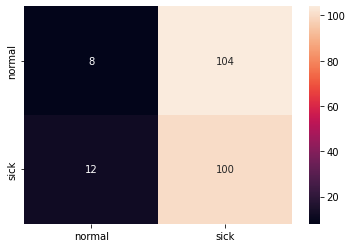

In [155]:
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['normal', 'sick'],yticklabels=['normal', 'sick'] )